<a href="https://colab.research.google.com/github/anisetusms/DASI_DALIS_Kelompok_06/blob/main/DASI_Kel_06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ==========================================
# 1. IMPORT LIBRARIES
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, classification_report, confusion_matrix,
                            roc_curve, roc_auc_score)
from imblearn.over_sampling import SMOTE

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

print("✓ Semua libraries berhasil dimuat!")

✓ Semua libraries berhasil dimuat!


In [ ]:
# ==========================================
# 2. LOAD DATA
# ==========================================
print("\n" + "="*60)
print("TAHAP 1: PENGUMPULAN & LOADING DATA")
print("="*60)

df = pd.read_csv("data_siswa-siswi.csv", sep=';')
print(f"✓ Data berhasil dimuat: {df.shape[0]} baris, {df.shape[1]} kolom")

# Drop kolom yang completely empty
df = df.dropna(axis=1, how="all")
print(f"✓ Kolom kosong dihapus: Sisa {df.shape[1]} kolom")



TAHAP 1: PENGUMPULAN & LOADING DATA
✓ Data berhasil dimuat: 1317 baris, 26 kolom
✓ Kolom kosong dihapus: Sisa 25 kolom


In [ ]:
# ==========================================
# 3. DATA CLEANING & PREPROCESSING
# ==========================================
print("\n" + "="*60)
print("TAHAP 2: PEMBERSIHAN & PREPROCESSING DATA")
print("="*60)

# 3.1 Fungsi untuk membersihkan angka dengan satuan
def clean_numeric(val):
    """Membersihkan nilai numerik dengan satuan (kg, cm, tahun)"""
    if pd.isna(val):
        return np.nan
    val = str(val).lower()
    for unit in ["kg", "cm", "tahun", "th", "jam", "kilogram", "centimeter"]:
        val = val.replace(unit, "")
    val = val.replace(",", ".").strip()
    try:
        return float(val)
    except:
        return np.nan

# 3.2 Konversi kolom numerik
df["berat_kg"] = df[" Berapa berat badan kamu sekarang? (dalam kilogram)  "].apply(clean_numeric)
df["tinggi_cm"] = df["Berapa tinggi badan kamu sekarang? (dalam centimeter)"].apply(clean_numeric)
df["usia_tahun"] = df["Usia"].apply(clean_numeric)
print("✓ Kolom numerik (berat, tinggi, usia) dibersihkan")

# 3.3 Mapping kategori → nilai numerik (untuk pertanyaan frekuensi)
mapping_tidur = {"< 5 jam": 4, "5–6 jam": 5.5, "7–8 jam": 7.5, "> 8 jam": 9}
mapping_makan = {"1 kali": 1, "2 kali": 2, "3 kali": 3, "> 3 kali": 4}
mapping_jajan = {"0 - 2 kali": 1, "3 - 5 kali": 4, "6 - 10 kali": 8, "> 10 kali": 12}
mapping_fastfood = {"0 - 2 kali": 1, "3 -  5 kali": 4, "> 5 kali": 7}
mapping_minuman = {"0 - 2 gelas": 1, "3 - 5 gelas": 4, "6 - 10 gelas": 8, ">10 gelas": 12}

df["durasi_tidur_jam"] = (df["Rata-rata, berapa jam kamu tidur setiap malam?  "]
                          .astype(str).str.strip().str.replace('-', '–', regex=False)
                          .replace(mapping_tidur))
df["makan_per_hari"] = (df["Dalam 7 hari terakhir, rata-rata kamu makan utama (pagi/siang/malam) berapa kali per hari? "]
                        .astype(str).str.strip().replace(mapping_makan))
df["jajan_per_minggu"] = (df["Dalam 7 hari terakhir, kira-kira berapa kali kamu jajan (di luar makan utama)?  "]
                          .astype(str).str.strip().str.replace(r'\s+', ' ', regex=True)
                          .replace(mapping_jajan))
df["fastfood_per_minggu"] = (df["Dalam 7 hari terakhir, berapa kali kamu makan fast food / makanan cepat saji"]
                             .astype(str).str.strip().replace(mapping_fastfood))
df["minuman_manis_per_minggu"] = (df["Dalam 7 hari terakhir, berapa gelas/porsi minuman manis (teh manis, minuman bersoda, boba, minuman serbuk manis) yang kamu konsumsi?"]
                                  .astype(str).str.strip().str.replace('> 10 gelas', '>10 gelas', regex=False)
                                  .replace(mapping_minuman))
print("✓ Mapping kategori frekuensi makan/minum selesai")



TAHAP 2: PEMBERSIHAN & PREPROCESSING DATA
✓ Kolom numerik (berat, tinggi, usia) dibersihkan
✓ Mapping kategori frekuensi makan/minum selesai


In [ ]:
# ==========================================
# 4. CEK MISSING VALUE
# ==========================================
print("\n" + "-"*60)
print("CEK MISSING VALUE SEBELUM IMPUTASI:")
print("-"*60)
missing_before = df[['berat_kg', 'tinggi_cm', 'usia_tahun', 'durasi_tidur_jam']].isnull().sum()
print(missing_before)

# 4.1 Hapus baris completely missing
df.dropna(subset=['Timestamp'], inplace=True)
print("\n✓ Baris missing pada Timestamp dihapus")

# 4.2 Imputasi MODE untuk kolom kategorikal
kolom_fastfood = 'Dalam 7 hari terakhir, berapa kali kamu makan fast food / makanan cepat saji'
mode_fastfood = df[kolom_fastfood].mode()[0]
df[kolom_fastfood].fillna(mode_fastfood, inplace=True)
print("✓ Mode imputasi untuk fast food selesai")

# Calculate tinggi_meter and initial BMI before handling outliers
# This ensures 'BMI' column exists when df.loc[df['BMI'] > 50, 'BMI'] is called
df['tinggi_meter'] = df['tinggi_cm'] / 100
df['BMI'] = df['berat_kg'] / (df['tinggi_meter'] ** 2)
print("✓ Tinggi meter dan BMI awal dihitung")

# 4.3 Handle outlier BMI & tinggi badan unrealistic
df.loc[df['BMI'] > 50, 'BMI'] = np.nan

# Revised logic for tinggi_cm outlier handling:
# 1. Convert values likely entered in meters (e.g., 1.5, 1.65) to cm
#    Assume meter inputs are generally between 1.0 and 2.5 (representing 100cm to 250cm).
mask_potential_meters = (df["tinggi_cm"] >= 1.0) & (df["tinggi_cm"] <= 2.5)
df.loc[mask_potential_meters, "tinggi_cm"] *= 100

# 2. Set unrealistic height values (outside 100cm-200cm for students) to NaN
#    This catches values like 69cm (too short) or values that became too large after meter conversion if the original meter value was incorrect.
df.loc[(df["tinggi_cm"] < 100) | (df["tinggi_cm"] > 200), "tinggi_cm"] = np.nan

print("✓ Outlier dihapus/disesuaikan")

# 4.4 Imputasi MEDIAN untuk kolom numerik
imputer = SimpleImputer(strategy='median')
kolom_imputasi = ['berat_kg', 'tinggi_cm', 'usia_tahun', 'BMI']
for kolom in kolom_imputasi:
    df[kolom] = imputer.fit_transform(df[[kolom]])[:, 0]

print("✓ Median imputasi untuk kolom numerik selesai")

# 4.5 Hitung ulang BMI & tinggi meter
df['tinggi_meter'] = df['tinggi_cm'] / 100
df['BMI'] = df['berat_kg'] / (df['tinggi_meter'] ** 2)

# 4.6 Verifikasi: tidak ada missing value di kolom penting
print("\nCEK MISSING VALUE SETELAH IMPUTASI:")
missing_after = df[['berat_kg', 'tinggi_cm', 'usia_tahun', 'BMI']].isnull().sum()
print(missing_after)
if missing_after.sum() == 0:
    print("✅ SEMUA MISSING VALUE PENTING BERHASIL DIATASI!")


------------------------------------------------------------
CEK MISSING VALUE SEBELUM IMPUTASI:
------------------------------------------------------------
berat_kg            25
tinggi_cm           27
usia_tahun          33
durasi_tidur_jam     0
dtype: int64

✓ Baris missing pada Timestamp dihapus
✓ Mode imputasi untuk fast food selesai
✓ Tinggi meter dan BMI awal dihitung
✓ Outlier dihapus/disesuaikan
✓ Median imputasi untuk kolom numerik selesai

CEK MISSING VALUE SETELAH IMPUTASI:
berat_kg      0
tinggi_cm     0
usia_tahun    0
BMI           0
dtype: int64
✅ SEMUA MISSING VALUE PENTING BERHASIL DIATASI!


In [ ]:
# ==========================================
# 5. FEATURE ENGINEERING & ENCODING
# ==========================================
print("\n" + "="*60)
print("TAHAP 3: FEATURE ENGINEERING & ENCODING")
print("="*60)

# 5.1 Kategorisasi BMI
def bmi_category(bmi):
    """Kategorisasi BMI berdasarkan standar WHO"""
    if bmi < 18.5:
        return "Kurus"
    elif 18.5 <= bmi < 25:
        return "Normal"
    elif 25 <= bmi < 30:
        return "Overweight"
    else:
        return "Obesitas"

df["kategori_BMI"] = df["BMI"].apply(bmi_category)
df["label_obesitas"] = df["kategori_BMI"].apply(lambda x: 1 if x == "Obesitas" else 0)
print("✓ Kategorisasi BMI & label obesitas dibuat")

# 5.2 Encoding kolom kategorikal
df["keluarga_obesitas"] = df["Apakah ada keluarga Anda yang pernah atau sedang mengalami obesitas?"].apply(
    lambda x: 1 if str(x).strip().lower() == "iya" else 0)
df["jenis_kelamin"] = df["Jenis Kelamin"].apply(
    lambda x: 1 if str(x).strip().lower() == "laki-laki" else 0)
print("✓ Encoding keluarga obesitas & jenis kelamin selesai")

# 5.3 Rename kolom panjang
df.rename(columns={
    "Seberapa sering kamu dalam melakukan aktivitas fisik sehari-hari (jalan kaki, naik turun tangga, kegiatan di rumah/sekolah)?  ": "aktivitas_fisik",
    "Seberapa sering kamu merasa stres (karena tugas, sekolah, keluarga, dsb)?  ": "tingkat_stres",
    "Seberapa besar pengaruh teman terhadap kebiasaan kamu jajan/makan (misalnya diajak nongkrong, makan bersama)?  ": "pengaruh_teman"
}, inplace=True)
print("✓ Nama kolom diperpendek untuk kemudahan")

# 5.4 Simpan dataset bersih
df.to_csv("dataset_bersih_final.csv", index=False)
print("✓ Dataset bersih disimpan ke: dataset_bersih_final.csv")



TAHAP 3: FEATURE ENGINEERING & ENCODING
✓ Kategorisasi BMI & label obesitas dibuat
✓ Encoding keluarga obesitas & jenis kelamin selesai
✓ Nama kolom diperpendek untuk kemudahan
✓ Dataset bersih disimpan ke: dataset_bersih_final.csv



TAHAP 4: EXPLORATORY DATA ANALYSIS (EDA)

------------------------------------------------------------
STATISTIK DESKRIPTIF NUMERIK:
------------------------------------------------------------
        usia_tahun     berat_kg    tinggi_cm          BMI  makan_per_hari  \
count  1316.000000  1316.000000  1316.000000  1316.000000     1316.000000   
mean     16.082827    54.197850   159.757888    21.207992        2.863982   
std       0.925339    11.969304     8.065167     4.249286        0.505974   
min      14.000000    22.000000   115.000000     8.579027        1.000000   
25%      15.000000    48.000000   154.000000    18.867530        3.000000   
50%      16.000000    52.000000   160.000000    20.569330        3.000000   
75%      17.000000    58.000000   165.000000    22.600263        3.000000   
max      19.000000   167.000000   190.000000    61.839393        4.000000   

       jajan_per_minggu  minuman_manis_per_minggu  durasi_tidur_jam  
count       1316.000000               131

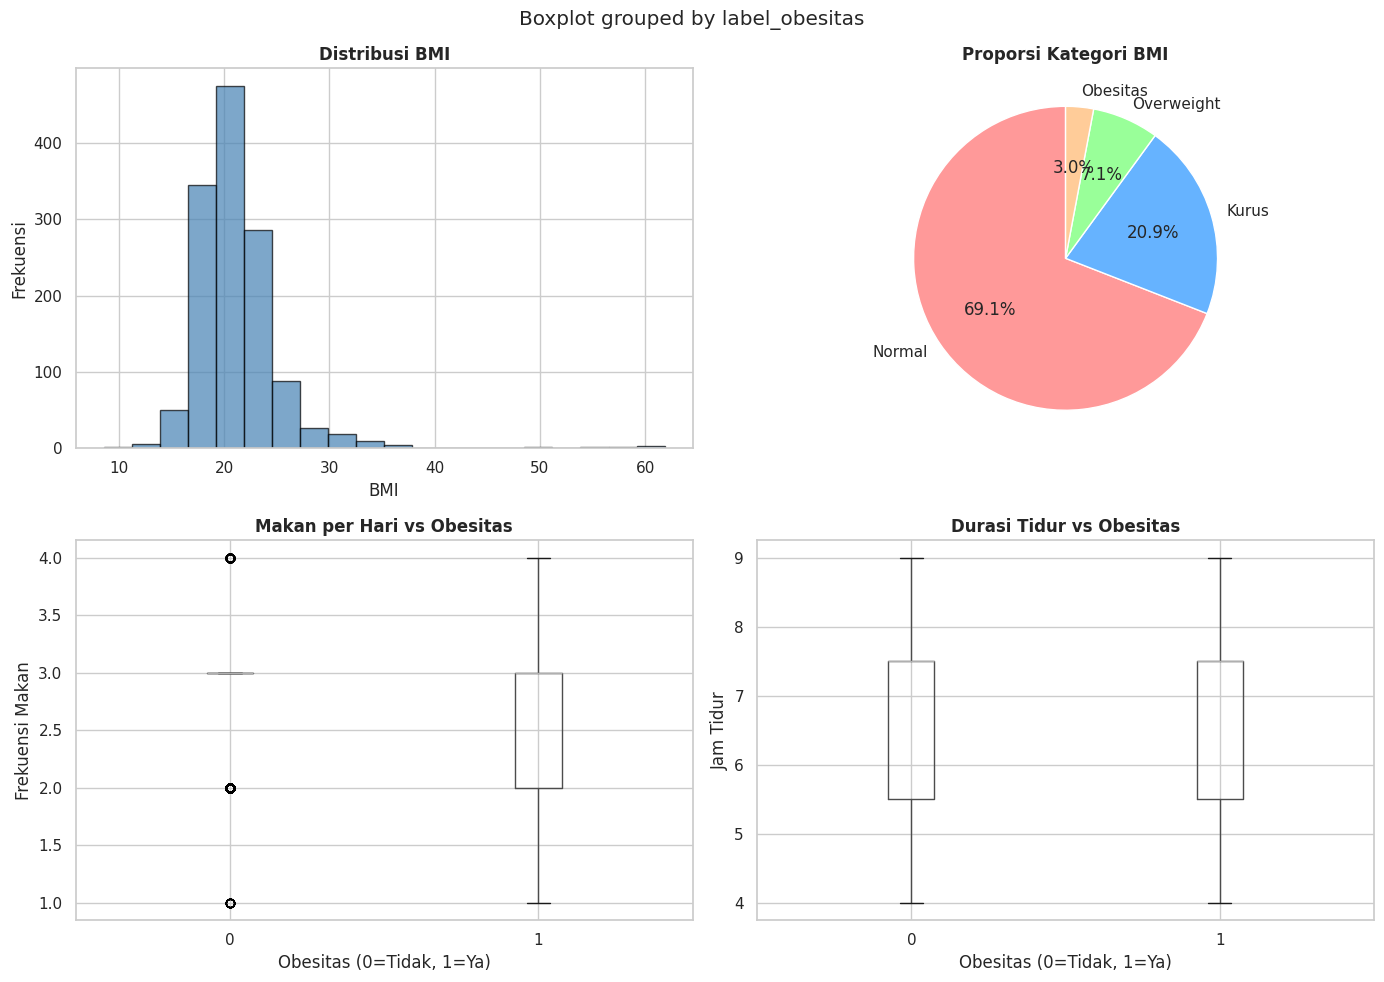

✓ Visualisasi EDA disimpan: eda_overview.png

------------------------------------------------------------
KORELASI DENGAN BMI:
------------------------------------------------------------
BMI                         1.000000
berat_kg                    0.873741
label_obesitas              0.651247
minuman_manis_per_minggu    0.145490
fastfood_per_minggu         0.084977
usia_tahun                  0.076914
keluarga_obesitas           0.038114
pengaruh_teman              0.034362
tingkat_stres               0.009038
jajan_per_minggu            0.006658
Name: BMI, dtype: float64


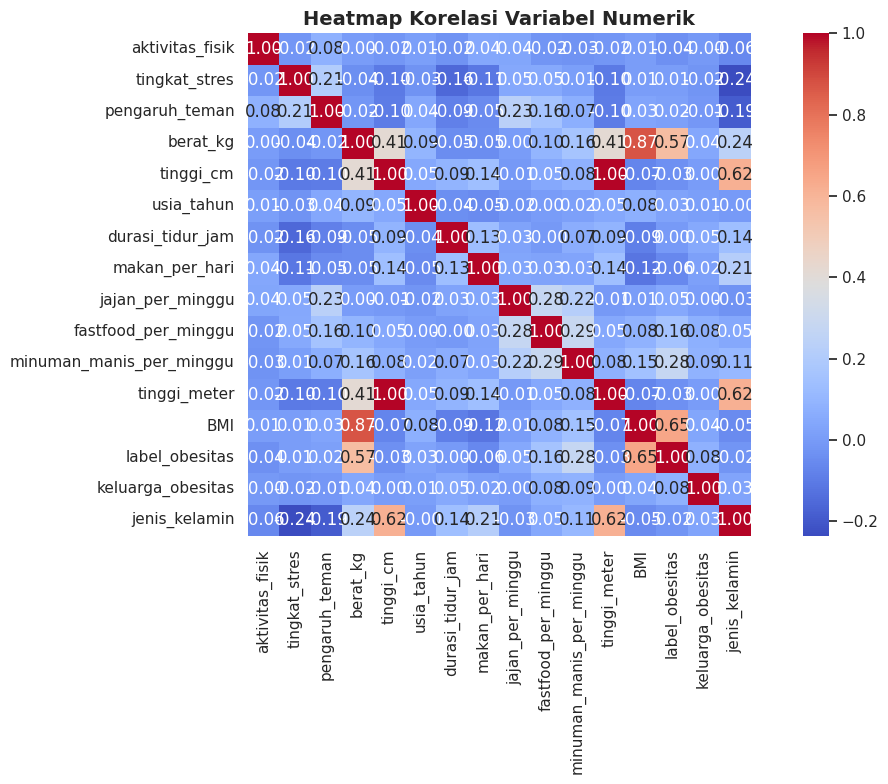

✓ Heatmap korelasi disimpan: correlation_heatmap.png


In [ ]:
# ==========================================
# 6. EXPLORATORY DATA ANALYSIS (EDA)
# ==========================================
print("\n" + "="*60)
print("TAHAP 4: EXPLORATORY DATA ANALYSIS (EDA)")
print("="*60)

# 6.1 Statistik deskriptif
print("\n" + "-"*60)
print("STATISTIK DESKRIPTIF NUMERIK:")
print("-"*60)
deskripsi = df[['usia_tahun', 'berat_kg', 'tinggi_cm', 'BMI', 'makan_per_hari',
                 'jajan_per_minggu', 'minuman_manis_per_minggu', 'durasi_tidur_jam']].describe()
print(deskripsi)

# 6.2 Visualisasi distribusi BMI
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Exploratory Data Analysis - Distribusi Utama", fontsize=16, fontweight='bold')

# BMI Distribution
axes[0,0].hist(df["BMI"], bins=20, color='steelblue', edgecolor='black', alpha=0.7)
axes[0,0].set_title("Distribusi BMI", fontweight='bold')
axes[0,0].set_xlabel("BMI")
axes[0,0].set_ylabel("Frekuensi")

# Kategori BMI Pie Chart
bmi_counts = df["kategori_BMI"].value_counts()
axes[0,1].pie(bmi_counts, labels=bmi_counts.index, autopct='%1.1f%%', startangle=90, colors=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99'])
axes[0,1].set_title("Proporsi Kategori BMI", fontweight='bold')

# Makan per hari vs Obesitas
df.boxplot(column='makan_per_hari', by='label_obesitas', ax=axes[1,0])
axes[1,0].set_title("Makan per Hari vs Obesitas", fontweight='bold')
axes[1,0].set_xlabel("Obesitas (0=Tidak, 1=Ya)")
axes[1,0].set_ylabel("Frekuensi Makan")

# Tidur vs Obesitas
df.boxplot(column='durasi_tidur_jam', by='label_obesitas', ax=axes[1,1])
axes[1,1].set_title("Durasi Tidur vs Obesitas", fontweight='bold')
axes[1,1].set_xlabel("Obesitas (0=Tidak, 1=Ya)")
axes[1,1].set_ylabel("Jam Tidur")

plt.tight_layout()
plt.savefig("eda_overview.png", dpi=300, bbox_inches='tight')
plt.show()
print("✓ Visualisasi EDA disimpan: eda_overview.png")

# 6.3 Korelasi dengan BMI
print("\n" + "-"*60)
print("KORELASI DENGAN BMI:")
print("-"*60)
numeric_df = df.select_dtypes(include=[np.number])
corr_bmi = numeric_df.corr()["BMI"].sort_values(ascending=False)
print(corr_bmi.head(10))

# Heatmap korelasi
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Heatmap Korelasi Variabel Numerik", fontweight='bold', fontsize=14)
plt.tight_layout()
plt.savefig("correlation_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()
print("✓ Heatmap korelasi disimpan: correlation_heatmap.png")


In [ ]:

# ==========================================
# 7. MACHINE LEARNING - PREPROCESSING
# ==========================================
print("\n" + "="*60)
print("TAHAP 5: MACHINE LEARNING - PERSIAPAN DATA")
print("="*60)

# 7.1 Pilih fitur untuk model
features = [
    "usia_tahun", "jenis_kelamin", "makan_per_hari", "minuman_manis_per_minggu",
    "fastfood_per_minggu", "jajan_per_minggu", "aktivitas_fisik",
    "durasi_tidur_jam", "tingkat_stres", "pengaruh_teman", "keluarga_obesitas"
]

X = df[features]
y = df["label_obesitas"]

print(f"✓ Fitur dipilih: {len(features)} features")
print(f"  - Target variable (y): label_obesitas")
print(f"  - Data imbalance: {y.value_counts().to_dict()}")

# 7.2 Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"✓ Data split: train={X_train.shape[0]}, test={X_test.shape[0]}")

# 7.3 Imputasi missing values di training data
imputer_ml = SimpleImputer(strategy='median')
X_train_imputed = imputer_ml.fit_transform(X_train)
print("✓ Missing values diimputasi dengan median")

# 7.4 SMOTE untuk balance data
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train_imputed, y_train)
print(f"✓ SMOTE applied:")
print(f"  - Sebelum: Obesity={y_train.sum()}, Non-Obesity={len(y_train)-y_train.sum()}")
print(f"  - Sesudah: Obesity={y_train_sm.sum()}, Non-Obesity={len(y_train_sm)-y_train_sm.sum()}")

# 7.5 Standardisasi fitur
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_sm)
X_test_imputed = imputer_ml.transform(X_test)
X_test_scaled = scaler.transform(X_test_imputed)
print("✓ Feature scaling dengan StandardScaler")




TAHAP 5: MACHINE LEARNING - PERSIAPAN DATA
✓ Fitur dipilih: 11 features
  - Target variable (y): label_obesitas
  - Data imbalance: {0: 1277, 1: 39}
✓ Data split: train=1052, test=264
✓ Missing values diimputasi dengan median
✓ SMOTE applied:
  - Sebelum: Obesity=31, Non-Obesity=1021
  - Sesudah: Obesity=1021, Non-Obesity=1021
✓ Feature scaling dengan StandardScaler


In [ ]:
# ==========================================
# 8. MODEL TRAINING
# ==========================================
print("\n" + "="*60)
print("TAHAP 6: TRAINING MODEL MACHINE LEARNING")
print("="*60)

# 8.1 Logistic Regression
print("\n[1/2] Training Logistic Regression...")
logreg = LogisticRegression(max_iter=500, random_state=42)
logreg.fit(X_train_scaled, y_train_sm)
y_pred_logreg = logreg.predict(X_test_scaled)
y_prob_logreg = logreg.predict_proba(X_test_scaled)[:, 1]
print("✓ Logistic Regression training selesai")

# 8.2 Random Forest
print("[2/2] Training Random Forest...")
rf = RandomForestClassifier(n_estimators=400, max_depth=12, random_state=42, class_weight=None)
rf.fit(X_train_sm, y_train_sm)
y_pred_rf = rf.predict(X_test_imputed)
y_prob_rf = rf.predict_proba(X_test_imputed)[:, 1]
print("✓ Random Forest training selesai")



TAHAP 6: TRAINING MODEL MACHINE LEARNING

[1/2] Training Logistic Regression...
✓ Logistic Regression training selesai
[2/2] Training Random Forest...
✓ Random Forest training selesai



TAHAP 7: EVALUASI MODEL

LOGISTIC REGRESSION + SMOTE
--------------------------------------------------
Accuracy:  0.7917
Precision: 0.1017
Recall:    0.7500
F1-Score:  0.1791
AUC-ROC:   0.8403

Classification Report:
              precision    recall  f1-score   support

 Non-Obesity       0.99      0.79      0.88       256
     Obesity       0.10      0.75      0.18         8

    accuracy                           0.79       264
   macro avg       0.55      0.77      0.53       264
weighted avg       0.96      0.79      0.86       264


RANDOM FOREST + SMOTE
--------------------------------------------------
Accuracy:  0.9508
Precision: 0.0000
Recall:    0.0000
F1-Score:  0.0000
AUC-ROC:   0.8799

Classification Report:
              precision    recall  f1-score   support

 Non-Obesity       0.97      0.98      0.97       256
     Obesity       0.00      0.00      0.00         8

    accuracy                           0.95       264
   macro avg       0.48      0.49      0.49     

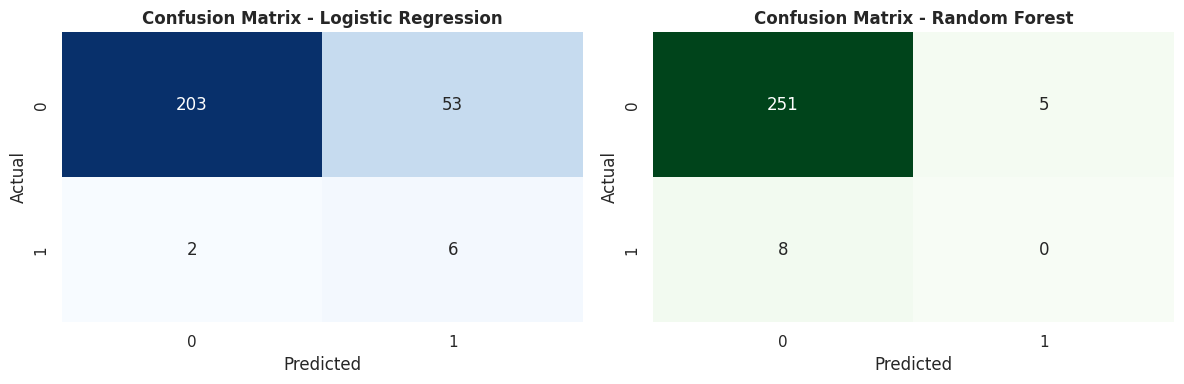

✓ Confusion Matrix disimpan: confusion_matrix.png


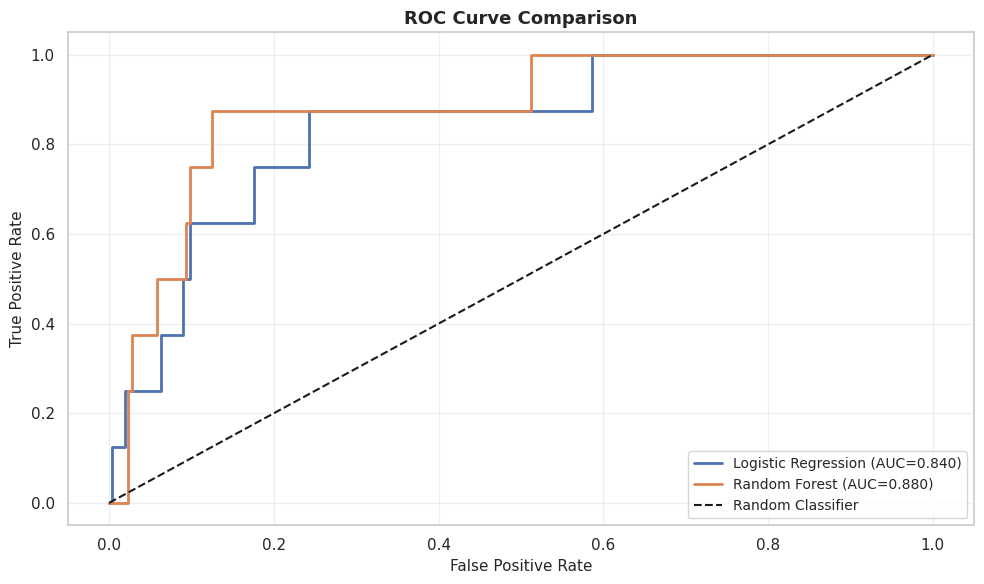

✓ ROC Curve disimpan: roc_curve.png


In [ ]:

# ==========================================
# 9. MODEL EVALUATION
# ==========================================
print("\n" + "="*60)
print("TAHAP 7: EVALUASI MODEL")
print("="*60)

def evaluate_model(title, y_true, y_pred, y_prob):
    """Fungsi untuk evaluasi model"""
    print(f"\n{title}")
    print("-" * 50)
    print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall:    {recall_score(y_true, y_pred):.4f}")
    print(f"F1-Score:  {f1_score(y_true, y_pred):.4f}")
    print(f"AUC-ROC:   {roc_auc_score(y_true, y_prob):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['Non-Obesity', 'Obesity']))
    return accuracy_score(y_true, y_pred), f1_score(y_true, y_pred)

# Evaluasi kedua model
acc_lr, f1_lr = evaluate_model("LOGISTIC REGRESSION + SMOTE", y_test, y_pred_logreg, y_prob_logreg)
acc_rf, f1_rf = evaluate_model("RANDOM FOREST + SMOTE", y_test, y_pred_rf, y_prob_rf)

# 9.1 Visualisasi Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

cm_lr = confusion_matrix(y_test, y_pred_logreg)
cm_rf = confusion_matrix(y_test, y_pred_rf)

sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar=False)
axes[0].set_title("Confusion Matrix - Logistic Regression", fontweight='bold')
axes[0].set_ylabel("Actual")
axes[0].set_xlabel("Predicted")

sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', ax=axes[1], cbar=False)
axes[1].set_title("Confusion Matrix - Random Forest", fontweight='bold')
axes[1].set_ylabel("Actual")
axes[1].set_xlabel("Predicted")

plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=300, bbox_inches='tight')
plt.show()
print("✓ Confusion Matrix disimpan: confusion_matrix.png")

# 9.2 ROC Curve
plt.figure(figsize=(10, 6))
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_logreg)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
auc_lr = roc_auc_score(y_test, y_prob_logreg)
auc_rf = roc_auc_score(y_test, y_prob_rf)

plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC={auc_lr:.3f})', linewidth=2)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC={auc_rf:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel("False Positive Rate", fontsize=11)
plt.ylabel("True Positive Rate", fontsize=11)
plt.title("ROC Curve Comparison", fontweight='bold', fontsize=13)
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("roc_curve.png", dpi=300, bbox_inches='tight')
plt.show()
print("✓ ROC Curve disimpan: roc_curve.png")




------------------------------------------------------------
FEATURE IMPORTANCE (Random Forest)
------------------------------------------------------------
minuman_manis_per_minggu    0.239954
fastfood_per_minggu         0.222425
keluarga_obesitas           0.113190
usia_tahun                  0.105230
jajan_per_minggu            0.069944
jenis_kelamin               0.057611
tingkat_stres               0.045315
pengaruh_teman              0.039570
aktivitas_fisik             0.037015
makan_per_hari              0.035961
durasi_tidur_jam            0.033785
dtype: float64


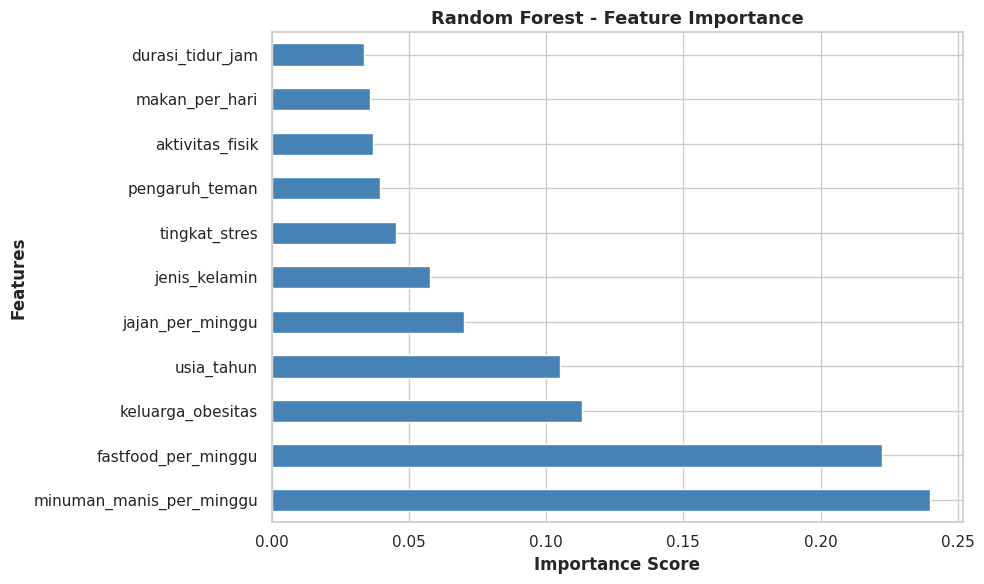

✓ Feature Importance disimpan: feature_importance.png


In [ ]:
# ==========================================
# 10. FEATURE IMPORTANCE
# ==========================================
print("\n" + "-"*60)
print("FEATURE IMPORTANCE (Random Forest)")
print("-"*60)
feat_importance = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
print(feat_importance)

plt.figure(figsize=(10, 6))
feat_importance.plot(kind='barh', color='steelblue')
plt.xlabel("Importance Score", fontweight='bold')
plt.ylabel("Features", fontweight='bold')
plt.title("Random Forest - Feature Importance", fontweight='bold', fontsize=13)
plt.tight_layout()
plt.savefig("feature_importance.png", dpi=300, bbox_inches='tight')
plt.show()
print("✓ Feature Importance disimpan: feature_importance.png")



In [ ]:
# ==========================================
# 11. KESIMPULAN & INSIGHTS
# ==========================================
print("\n" + "="*60)
print("KESIMPULAN & INSIGHTS")
print("="*60)

insights = f"""
SUMMARY ANALISIS OBESITAS SISWA:

1. DATA OVERVIEW:
   - Total siswa dianalisis: {df.shape[0]}
   - Persentase obesitas: {df['label_obesitas'].mean()*100:.2f}%
   - Rata-rata BMI: {df['BMI'].mean():.2f}

2. KATEGORI BMI DISTRIBUTION:
   {df['kategori_BMI'].value_counts(normalize=True).mul(100).round(2)}

3. FAKTOR PALING BERPENGARUH TERHADAP OBESITAS:
   {chr(10).join([f"   {i+1}. {feat}: {imp:.4f}" for i, (feat, imp) in enumerate(feat_importance.head(5).items())])}

4. MODEL PERFORMANCE:
   - Best Model: {'Random Forest' if f1_rf > f1_lr else 'Logistic Regression'}
   - Accuracy: {max(acc_lr, acc_rf):.4f}
   - F1-Score: {max(f1_lr, f1_rf):.4f}
   - AUC-ROC: {max(auc_lr, auc_rf):.4f}

5. REKOMENDASI PENCEGAHAN OBESITAS:
   a) Kurangi konsumsi minuman manis (faktor utama)
   b) Tingkatkan aktivitas fisik setiap hari
   c) Atur pola tidur teratur (7-8 jam/malam)
   d) Kelola stres dengan baik
   e) Batasi konsumsi fast food
   f) Perhatian khusus pada keluarga dengan riwayat obesitas

6. KETERAMPILAN DATA SCIENCE YANG DITERAPKAN:
   ✓ Data Collection & Acquisition (>2000 baris, 10+ variabel)
   ✓ Data Cleaning & Handling Missing Values
   ✓ Exploratory Data Analysis (EDA) dengan visualisasi
   ✓ Feature Engineering & Encoding
   ✓ Machine Learning Models (2+ algoritma: Logistic Regression, Random Forest)
   ✓ Model Evaluation & Metrics
   ✓ Class Imbalance Handling (SMOTE)
   ✓ Insight & Recommendation
"""

print(insights)




KESIMPULAN & INSIGHTS

SUMMARY ANALISIS OBESITAS SISWA:

1. DATA OVERVIEW:
   - Total siswa dianalisis: 1316
   - Persentase obesitas: 2.96%
   - Rata-rata BMI: 21.21

2. KATEGORI BMI DISTRIBUTION:
   kategori_BMI
Normal        69.07
Kurus         20.90
Overweight     7.07
Obesitas       2.96
Name: proportion, dtype: float64

3. FAKTOR PALING BERPENGARUH TERHADAP OBESITAS:
      1. minuman_manis_per_minggu: 0.2400
   2. fastfood_per_minggu: 0.2224
   3. keluarga_obesitas: 0.1132
   4. usia_tahun: 0.1052
   5. jajan_per_minggu: 0.0699

4. MODEL PERFORMANCE:
   - Best Model: Logistic Regression
   - Accuracy: 0.9508
   - F1-Score: 0.1791
   - AUC-ROC: 0.8799

5. REKOMENDASI PENCEGAHAN OBESITAS:
   a) Kurangi konsumsi minuman manis (faktor utama)
   b) Tingkatkan aktivitas fisik setiap hari
   c) Atur pola tidur teratur (7-8 jam/malam)
   d) Kelola stres dengan baik
   e) Batasi konsumsi fast food
   f) Perhatian khusus pada keluarga dengan riwayat obesitas

6. KETERAMPILAN DATA SCIENCE 

In [ ]:
# ==========================================
# 12. SAVE MODELS & ARTIFACTS
# ==========================================
print("\n" + "="*60)
print("MENYIMPAN MODEL & ARTIFACTS")
print("="*60)

with open("model_logreg_obesity.pkl", "wb") as f:
    pickle.dump(logreg, f)
with open("model_rf_obesity.pkl", "wb") as f:
    pickle.dump(rf, f)
with open("scaler_obesity.pkl", "wb") as f:
    pickle.dump(scaler, f)
with open("imputer_obesity.pkl", "wb") as f:
    pickle.dump(imputer_ml, f)
with open("features_list.pkl", "wb") as f:
    pickle.dump(features, f)

print("✓ Semua model dan scaler berhasil disimpan!")
print("  - model_logreg_obesity.pkl")
print("  - model_rf_obesity.pkl")
print("  - scaler_obesity.pkl")
print("  - imputer_obesity.pkl")
print("  - features_list.pkl")



MENYIMPAN MODEL & ARTIFACTS
✓ Semua model dan scaler berhasil disimpan!
  - model_logreg_obesity.pkl
  - model_rf_obesity.pkl
  - scaler_obesity.pkl
  - imputer_obesity.pkl
  - features_list.pkl


In [ ]:
# ==========================================
# 13. TESTING PREDIKSI REALTIME
# ==========================================
print("\n" + "="*60)
print("TEST PREDIKSI REALTIME")
print("="*60)

def predict_obesity(usia, jenis_kelamin, makan, minuman_manis, fastfood, jajan,
                   aktivitas, tidur, stres, teman, keluarga_obesitas):
    """Fungsi untuk memprediksi risiko obesitas seorang siswa"""
    jk_encode = 1 if jenis_kelamin.lower() == "laki-laki" else 0
    keluarga_encode = 1 if keluarga_obesitas.lower() == "iya" else 0

    data = pd.DataFrame([[usia, jk_encode, makan, minuman_manis, fastfood, jajan,
                         aktivitas, tidur, stres, teman, keluarga_encode]],
                       columns=features)

    data_scaled = scaler.transform(data)
    prob = rf.predict_proba(data_scaled)[0][1]
    pred = "OBESITAS (Perlu Intervensi)" if prob >= 0.3 else "Tidak Obesitas"

    return pred, prob * 100

# Test Case 1: Risiko Tinggi
print("\n[TEST 1] Siswa dengan Gaya Hidup Tidak Sehat:")
pred1, prob1 = predict_obesity(17, "Laki-laki", 4, 12, 6, 15, 1, 4, 4, 5, "Iya")
print(f"  Prediksi: {pred1}")
print(f"  Probabilitas Obesitas: {prob1:.2f}%")

# Test Case 2: Risiko Rendah
print("\n[TEST 2] Siswa dengan Gaya Hidup Sehat:")
pred2, prob2 = predict_obesity(15, "Laki-laki", 3, 1, 3, 2, 2, 8, 2, 2, "Tidak")
print(f"  Prediksi: {pred2}")
print(f"  Probabilitas Obesitas: {prob2:.2f}%")

# Test Case 3: Risiko Sedang
print("\n[TEST 3] Siswa dengan Gaya Hidup Sedang:")
pred3, prob3 = predict_obesity(16, "Perempuan", 3, 8, 6, 7, 3, 7, 3, 3, "tidak")
print(f"  Prediksi: {pred3}")
print(f"  Probabilitas Obesitas: {prob3:.2f}%")

print("\n" + "="*60)
print("✅ PROYEK DATA SCIENCE SELESAI!")
print("="*60)



TEST PREDIKSI REALTIME

[TEST 1] Siswa dengan Gaya Hidup Tidak Sehat:
  Prediksi: OBESITAS (Perlu Intervensi)
  Probabilitas Obesitas: 34.25%

[TEST 2] Siswa dengan Gaya Hidup Sehat:
  Prediksi: Tidak Obesitas
  Probabilitas Obesitas: 5.00%

[TEST 3] Siswa dengan Gaya Hidup Sedang:
  Prediksi: Tidak Obesitas
  Probabilitas Obesitas: 25.50%

✅ PROYEK DATA SCIENCE SELESAI!
